<a href="https://colab.research.google.com/github/T1M0THY1337/big-data-prediction-challenge/blob/master/prediction_challenge_solution_version_19_final_4_LinearSVC%2BExtraTreesClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction Challenge by Sebastian Krakau and Tim Schalk

Your job is to predict whether or not a person will become a customer of a bank. The data itself contains basic demographic information about numerous  customers as well as data related to phone-based marketing calls during specific campaigns.

# Header

## Version 9.4


---

## Data Dictionary

<table style="width: 100%;">
    <thead>
        <tr>
            <th style="width: 30%; text-align: left;">Feature</th>
            <th style="width: 70%; text-align: left;">Description</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>date</td>
            <td>The last contact date</td>
        </tr>
        <tr>
            <td>age</td>
            <td>The age of the customer</td>
        </tr>
        <tr>
            <td>marital_status</td>
            <td>The marital status of the customer</td>
        </tr>
        <tr>
            <td>education</td>
            <td>The educationan of the customer</td>
        </tr>
        <tr>
            <td>job</td>
            <td>The type of job of the customer</td>
        </tr>
        <tr>
            <td>credit_default</td>
            <td>Whether or not the customer has a credit in default</td>
        </tr>
        <tr>
            <td>housing_loan</td>
            <td>Whether or not the customer has a housing loan</td>
        </tr>
        <tr>
            <td>personal_loan</td>
            <td>Whether or not the customer has a personal loan</td>
        </tr>
        <tr>
            <td>communication_type</td>
            <td>The type of contact communication</td>
        </tr>
        <tr>
            <td>n_contacts_campaign</td>
            <td>The number of contacts performed during this marketing campaign and for this customer</td>
        </tr>
        <tr>
            <td>days_since_last_contact</td>
            <td>The number of days passed by after the customer was last contacted from a previous domain</td>
        </tr>
        <tr>
            <td>n_contacts_before</td>
            <td>The number of contacts performed before this marketing campaign and for this customer</td>
        </tr>
        <tr>
            <td>previous_conversion</td>
            <td>Whether or not the customer has been a customer before</td>
        </tr>
        <tr>
            <td>success</td>
            <td>Whether or not the customer became an actual customer (target variable)</td>
        </tr>
    </tbody>   
</table>   

# Programming

## Package Import

In [0]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sys as sys
import csv, datetime
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import uniform, randint
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, make_scorer, roc_auc_score, roc_curve, recall_score, precision_score
from sklearn.model_selection import RandomizedSearchCV, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

## Data Import

In [0]:
original_dataset = pd.read_csv(
    'https://raw.githubusercontent.com/saschaschworm/big-data-and-data-science/' +
    'master/datasets/prediction-challenge/dataset.csv', 
    index_col='identifier', parse_dates=['date'])

original_dataset_prediction = pd.read_csv(
    'https://raw.githubusercontent.com/saschaschworm/big-data-and-data-science/' +
    'master/datasets/prediction-challenge/prediction-dataset.csv', 
    index_col='identifier', parse_dates=['date'])

# https://www.kaggle.com/sohier/interest-rate-records
dataset_PrimeRate = pd.read_csv(
    'https://raw.githubusercontent.com/T1M0THY1337/big-data-prediction-challenge/' +
    'master/datasets/dataset_PrimeRate.csv', parse_dates=['time_period'])

## Options

In [0]:
x_random_state = 1909
x_rscv_n_iter = 10 # For param_distributions and RandomizedSearchCV

## Feature Engineering

In [0]:
# Create some new features based on the given features
# or enrich the dataset with features from datasets.

### A problem with the data set: It is unbalanced:

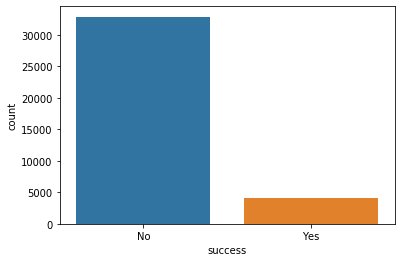

In [0]:
sns.countplot(data=original_dataset,x="success")

### Following function will be needed for Feature Engineering:

In [0]:
def getWeekendDay(inDate):
  if (inDate.weekday == 'Saturday') or (inDate.weekday == 'Sunday'):
    return True
  else:
    return False

In [0]:
def getAgeGroup(inAge):
  if (inAge < 28):
    return 'young'
  elif (49 > inAge > 27):
    return 'younger'
  elif (61 > inAge > 48):
    return 'older'
  else:
    return 'old'

In [0]:
def getDurationGroup(inDuration):
  if (inDuration < 250):
    return 'very_short'
  elif (250 < inDuration < 500):
    return 'short'
  elif (500 < inDuration < 750):
    return 'lower_medium'
  elif (750 < inDuration < 1000):
    return 'medium'
  elif (1000 < inDuration < 1250):
    return 'higher_medium'
  elif (1250 < inDuration < 1500):
    return 'long'
  elif (1500 < inDuration < 1750):
    return 'very_long'
  else:
    return 'very_big_call'

In [0]:
def getSeason(inMonth):
  if(3 < inMonth < 6):
    return 'spring'
  if(5 < inMonth < 9):
    return 'summer'
  if(8 < inMonth < 12):
    return 'fall'
  else:
    return 'winter'

In [0]:
def getJobGroup(inJob):
  if(inJob == "Unknown"):
    return 'True'
  elif(inJob == "Unemployed" or inJob == "Student" or inJob == "Pensioner"):
    return 'False'
  else:
    return 'True'

In [0]:
def getContactCampaignGroup(inN_contacts_campaign):
  if (inN_contacts_campaign < 15):
    return 'xsmall'
  elif (15 < inN_contacts_campaign < 30):
    return 'small'
  elif (30 < inN_contacts_campaign < 45):
    return 'medium'
  else:
    return 'high'

In [0]:
def getContactsBeforeGroup(inN_contacts_before):
  if (inN_contacts_before < 3):
    return 'small'
  elif (3 < inN_contacts_before < 6):
    return 'medium'
  else:
    return 'high'

In [0]:
def getLastContactGroup(inDays_since_last_contact):
  if (inDays_since_last_contact < 0):
    return 'no_contact'
  elif (0 < inDays_since_last_contact < 5):
    return 'less'
  elif (5 < inDays_since_last_contact < 10):
    return 'ok'
  elif (10 < inDays_since_last_contact < 15):
    return 'medium'
  elif (15 < inDays_since_last_contact < 20):
    return 'more'
  else:
    return 'high'  

In [0]:
def getPrimeRate(inDate):
  prime_rate = dataset_PrimeRate[dataset_PrimeRate['time_period'] == inDate]
  #prime_rate = prime_rate.iat[0,0].strftime(format='%Y-%m-%d')
  prime_rate = prime_rate['prime_rate']
  prime_rate = prime_rate.iat[0]
  return prime_rate

In [0]:
def getWeekDay(inDate):
  return inDate.day_name()

### An Overview over all features in the dataset:

In [0]:
featureList = [[1,   'date',                           'date',     0],
               [2,   'dateYear',                       'string',   1],
               [3,   'dateMonth',                      'string',   1],
               [4,   'dateWeekday',                    'string',   1],
               [5,   'dateWeekendDay',                 'boolean',  0],
               [6,   'dateSeason',                     'string',   1],
               [7,   'n_contacts_campaign',            'integer',  1],
               [8,   'n_contacts_campaignGroup',       'string',   0],
               [9,   'n_contacts_before',              'integer',  1],
               [10,  'n_contacts_beforeGroup',         'string',   1],
               [11,  'days_since_last_contact',        'integer',  1],
               [12,  'days_since_last_contactGroup',   'string',   1],
               [13,  'age',                            'integer',  0],
               [14,  'ageGroup',                       'string',   1],
               [15,  'job',                            'string',   0],
               [16,  'jobGroup',                       'boolean',  1],
               [17,  'marital_status',                 'string',   1],
               [18,  'education',                      'string',   1],
               [19,  'credit_default',                 'string',   1],
               [20,  'housing_loan',                   'string',   1],
               [21,  'personal_loan',                  'string',   1],
               [22,  'communication_type',             'string',   1],
               [23,  'previous_conversion',            'string',   1],
               [24,  'duration',                       'integer',  1],
               [25,  'durationGroup',                  'string',   1],
               [26,  'prime_rate',                     'float',    1]]


### Editing and Enhancing the features:

In [0]:
def getModifiedDataframe(inDataframe):

  # 00 - init
  outDataframe = pd.DataFrame()

  # 01 - date
  outDataframe['date'] = pd.to_datetime(inDataframe['date'])

  # 02 - dateYear
  outDataframe.insert(1, "dateYear", outDataframe['date'], allow_duplicates=True)
  outDataframe.dateYear = outDataframe['dateYear'].dt.year

  # 03 - dateMonth
  outDataframe.insert(2, "dateMonth", outDataframe['date'], allow_duplicates=True)
  outDataframe.dateMonth = outDataframe['dateMonth'].dt.month

  # 04 - dateWeekday
  outDataframe.insert(3, "dateWeekday", outDataframe['date'], allow_duplicates=True)
  outDataframe.dateWeekday = outDataframe.dateWeekday.apply(getWeekDay)

  # 05 - dateWeekendDay
  outDataframe.insert(4, "dateWeekendDay", outDataframe['date'], allow_duplicates=True)
  outDataframe.dateWeekendDay = outDataframe.dateWeekendDay.apply(getWeekendDay)

  # 06 - dateSeason
  outDataframe.insert(5, "dateSeason", outDataframe['dateMonth'], allow_duplicates=True)
  outDataframe.dateSeason = outDataframe.dateSeason.apply(getSeason)

  # 07 - n_contacts_campaign
  outDataframe.insert(6, "n_contacts_campaign", inDataframe['n_contacts_campaign'], allow_duplicates=True)

  # 08 - n_contacts_campaignGroup
  outDataframe.insert(7, "n_contacts_campaignGroup", inDataframe['n_contacts_campaign'], allow_duplicates=True)
  outDataframe.n_contacts_campaignGroup = outDataframe.n_contacts_campaign.apply(getContactCampaignGroup)

  # 09 - n_contacts_before
  outDataframe.insert(8, "n_contacts_before", inDataframe['n_contacts_before'], allow_duplicates=True)

  # 10 - n_contacts_beforeGroup
  outDataframe.insert(9, "n_contacts_beforeGroup", inDataframe['n_contacts_before'], allow_duplicates=True)
  outDataframe.n_contacts_beforeGroup = outDataframe.n_contacts_before.apply(getContactsBeforeGroup)

  # 11 - days_since_last_contact
  outDataframe.insert(10, "days_since_last_contact", inDataframe['days_since_last_contact'], allow_duplicates=True)

  # 12 - days_since_last_contactGroup
  outDataframe.insert(11, "days_since_last_contactGroup", inDataframe['days_since_last_contact'], allow_duplicates=True)
  outDataframe.days_since_last_contactGroup = outDataframe.days_since_last_contact.apply(getLastContactGroup)

  # 13 - age
  outDataframe.insert(12, "age", inDataframe['age'], allow_duplicates=True)

  # 14 - ageGroup
  outDataframe.insert(13, "ageGroup", inDataframe['age'], allow_duplicates=True)
  outDataframe.ageGroup = outDataframe.ageGroup.apply(getAgeGroup)

  # 15 - job
  outDataframe.insert(14, "job", inDataframe['job'], allow_duplicates=True)

  # 16 - jobGroup
  outDataframe.insert(15, "jobGroup", inDataframe['job'], allow_duplicates=True)
  outDataframe.jobGroup = outDataframe.jobGroup.apply(getJobGroup)

  # 17 - marital_status
  outDataframe.insert(16, "marital_status", inDataframe['marital_status'], allow_duplicates=True)

  # 18 - education
  outDataframe.insert(17, "education", inDataframe['education'], allow_duplicates=True)

  # 19 - credit_default
  outDataframe.insert(18, "credit_default", inDataframe['credit_default'], allow_duplicates=True)

  # 20 - housing_loan
  outDataframe.insert(19, "housing_loan", inDataframe['housing_loan'], allow_duplicates=True)

  # 21 - personal_loan
  outDataframe.insert(20, "personal_loan", inDataframe['personal_loan'], allow_duplicates=True)

  # 22 - communication_type
  outDataframe.insert(21, "communication_type", inDataframe['communication_type'], allow_duplicates=True)

  # 23 - previous_conversion
  outDataframe.insert(22, "previous_conversion", inDataframe['previous_conversion'], allow_duplicates=True)

  # 24 - duration
  outDataframe.insert(23, "duration", inDataframe['duration'], allow_duplicates=True)

  # 25 - durationGroup
  outDataframe.insert(24, "durationGroup", inDataframe['duration'], allow_duplicates=True)
  outDataframe.durationGroup = outDataframe.durationGroup.apply(getDurationGroup)

  # 26 - prime_rate
  outDataframe.insert(25, "prime_rate", inDataframe['date'], allow_duplicates=True)
  outDataframe.prime_rate = outDataframe.prime_rate.apply(getPrimeRate)

  return outDataframe

### Cleaning the training data set:

In [0]:
def getModifiedTrainingSet(inDataframe, inDataframeSuccess):

  outDataframe = inDataframe

  # 27 - success
  outDataframe.insert(26, "success", inDataframeSuccess, allow_duplicates=True)

  # Remove all datasets with feature date more the 2 "Unkowns"
  outDataframe = outDataframe.loc[outDataframe.isin(["Unknown"]).mean(axis=1) < 0.13]

  # Remove all datasets with duration = 0
  outDataframe = outDataframe[(outDataframe['duration'] > 0)]

  # Remove all datasets with credit_default = 'Yes'
  outDataframe = outDataframe[(outDataframe['credit_default'] != 'Yes')]

  # Remove all datasets with education = 'Illiterate'
  outDataframe = outDataframe[(outDataframe['education'] != 'Illiterate')]

  # Capping Feature duration
  upper_lim = outDataframe['duration'].quantile(.97)
  outDataframe.loc[(outDataframe['duration'] > upper_lim), 'duration'] = upper_lim

  # Resample the imbalanced dataframe | https://www.kaggle.com/anilkay/handleimbalanceddataclassification

  majority=outDataframe[outDataframe["success"]=="No"]
  minority=outDataframe[outDataframe["success"]=="Yes"]
  minority_upsampled = resample(minority, replace=True, n_samples=16000, random_state=x_random_state)
  outDataframe = pd.concat([majority,minority_upsampled])

  return outDataframe

### Following functions returns the complete feature list, the list with only numeric values and the list with categorical values:

In [0]:
def getFeatureList():
  listSize = 0
  for y in featureList:
    if(y[3] == 1):
      if(listSize == 0):
        outList = [(y[1])]
      else:
        outList.append(y[1])
      listSize = listSize + 1
  return outList

In [0]:
def getFeatureListNumeric():
  listSize = 0
  for y in featureList:
    if((y[3] == 1) and ((y[2] == 'integer') or (y[2] == 'float'))):
      if(listSize == 0):
        outList = [(y[1])]
      else:
        outList.append(y[1])
      listSize = listSize + 1
  return outList

In [0]:
def getFeatureListCategoric():
  listSize = 0
  for y in featureList:
    if((y[3] == 1) and ((y[2] == 'string') or (y[2] == 'boolean'))):
      if(listSize == 0):
        outList = [(y[1])]
      else:
        outList.append(y[1])
      listSize = listSize + 1
  return outList

### Initiate with the execution of feature engineering:

In [0]:
dataset = getModifiedDataframe(original_dataset)
dataset = getModifiedTrainingSet(dataset, original_dataset['success'])
dataset_prediction = getModifiedDataframe(original_dataset_prediction)
dataset_prediction = dataset_prediction[getFeatureList()]

### Final target feature after oversampling:

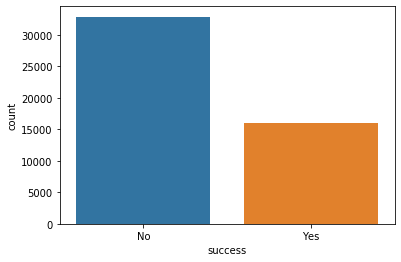

In [0]:
sns.countplot(data=dataset,x="success")

### Save the Final Feature set and target feature 

In [0]:
X = dataset[getFeatureList()]
y = dataset['success']

### An overview of the important features in data:

In [0]:
X_dummie = pd.get_dummies(X, prefix_sep='_', drop_first=True)

In [0]:
model = ExtraTreesClassifier()
model.fit(X_dummie,y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [0]:
feat_importances = pd.Series(model.feature_importances_, index=X_dummie.columns)

### The top 10 most important features in data:

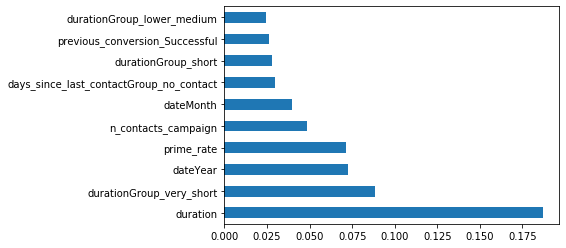

In [0]:
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

### The top 15 most unimportant feature in data:

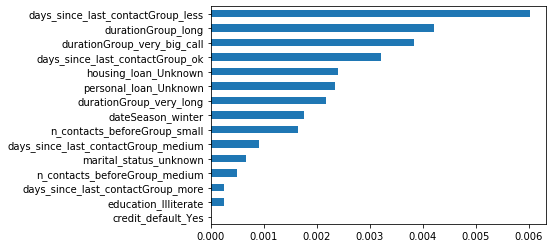

In [0]:
feat_importances.nsmallest(15).plot(kind='barh')
plt.show()

## Model, Pipeline and Scoring Initialization

In [0]:
ratio = float(np.sum(y == "No")) / np.sum(y == "Yes")
f'Optimal ratio at: {ratio}'

'Optimal ratio at: 2.054625'

In [0]:
classifier = xgb.XGBClassifier(n_jobs=-1, random_state=x_random_state, objective='binary:logistic', scale_pos_weight=ratio)

In [0]:
x_rscv = StratifiedKFold(n_splits=5, shuffle=True, random_state=x_random_state)
x_rscv = x_rscv.split(X, y)

In [0]:
recall_scorer = make_scorer(recall_score, average='binary', pos_label='Yes')
f1_scorer = make_scorer(f1_score, average='binary', pos_label='Yes')

In [0]:
numeric_features = getFeatureListNumeric()
numeric_transformer = Pipeline([
    ('scaler', MinMaxScaler()),
])

categorical_features = getFeatureListCategoric()
categorical_transformer = Pipeline([
    ('onehotencoder', OneHotEncoder(drop='first')),
])

preprocessor = ColumnTransformer([
    ('numeric_transformer', numeric_transformer, numeric_features),
    ('categorical_transformer', categorical_transformer, categorical_features)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, random_state=x_random_state))),
    ('classifier', classifier)
])

In [0]:
param_distributions = {
                        "classifier__learning_rate": uniform.rvs(0.0001, 0.1, size=x_rscv_n_iter),
                        "classifier__gamma" : uniform.rvs(0, 2, size=x_rscv_n_iter),
                        "classifier__max_depth": randint.rvs(2, 100, size=x_rscv_n_iter),
                        "classifier__colsample_bytree": uniform.rvs(0.1, 0.9, size=x_rscv_n_iter),
                        "classifier__subsample": uniform.rvs(0.1, 0.9, size=x_rscv_n_iter),
                        "classifier__reg_alpha": uniform.rvs(0, 0.9, size=x_rscv_n_iter),
                        "classifier__reg_lambda": uniform.rvs(0.0001, 5, size=x_rscv_n_iter),
                        "classifier__min_child_weight": randint.rvs(1, 7, size=x_rscv_n_iter),
                        "classifier__n_estimators": randint.rvs(100, 1000, size=x_rscv_n_iter)
                      }

In [0]:
search = RandomizedSearchCV(
    pipeline, param_distributions=param_distributions, n_iter=x_rscv_n_iter, scoring={'recall_score': recall_scorer, 'f1_score': f1_scorer}, 
    n_jobs=-1, cv=x_rscv, random_state=x_random_state, refit='f1_score', return_train_score=True)

In [0]:
search = search.fit(X, y)

In [0]:
f'Optimal parameters: {search.best_params_}'

## Evaluation

In [0]:
training_score_f1 = search.cv_results_['mean_train_f1_score'][search.best_index_] * 100
test_score_f1 = search.cv_results_['mean_test_f1_score'][search.best_index_] * 100
f'Mean F1 Score (Training/Test): {training_score_f1:.2f}%/{test_score_f1:.2f}%'

In [0]:
training_score_recall = search.cv_results_['mean_train_recall_score'][search.best_index_] * 100
test_score_recall = search.cv_results_['mean_test_recall_score'][search.best_index_] * 100
f'Mean Recall Score (Training/Test): {training_score_recall:.2f}%/{test_score_recall:.2f}%'

In [0]:
mean_fit_time = search.cv_results_['mean_fit_time'][search.best_index_]
mean_score_time = search.cv_results_['mean_score_time'][search.best_index_]
f'Mean mean_fit_time / mean_score_time: {mean_fit_time:.2f}/{mean_score_time:.2f}'

## Write into the Log-File

In [0]:
# datetime;alpha;lambda;random_state;n_estimators_min;n_estimators_max;max_depth_min;x_max_depth_max;best_n_estimators;best_max_depth;best_learning_rate;f1_training;f1_test;std_train_score;std_test_score

logData = [[datetime.now()
            ,search.best_params_['classifier__learning_rate']
            ,search.best_params_['classifier__gamma']
            ,search.best_params_['classifier__max_depth']
            ,search.best_params_['classifier__colsample_bytree']
            ,search.best_params_['classifier__subsample']
            ,search.best_params_['classifier__reg_alpha']
            ,search.best_params_['classifier__reg_lambda']
            ,search.best_params_['classifier__min_child_weight']
            ,search.best_params_['classifier__n_estimators']
            ,training_score_f1
            ,test_score_f1
            ,search.cv_results_['mean_fit_time'][search.best_index_]
            ,search.cv_results_['mean_score_time'][search.best_index_]]]
with open('log2.csv', 'a') as csvfile:
  writer = csv.writer(csvfile, delimiter=';')
  writer.writerows(logData)

## Prediction

In [0]:
predictions = search.best_estimator_.predict(dataset_prediction)

### Submission Dataset Preparation

Your upload to the Online-Campus should contain your written report (the actual seminar paper), this notebook as file as well as the generated submission dataset with your predictions.

In [0]:
submission = pd.DataFrame(
    predictions, index=dataset_prediction.index, columns=['prediction'])

In [0]:
matriculation_number = '467429'

In [0]:
submission.to_csv(
    f'./{test_score_f1:.2f}-submission-{matriculation_number}.csv', index_label='identifier')

# Nützliche Links
* XGboost Implementation: [https://www.datacamp.com/community/tutorials/xgboost-in-python](https://www.datacamp.com/community/tutorials/xgboost-in-python)
* XGBoost Parameter List: [https://xgboost.readthedocs.io/en/latest/parameter.html](https://xgboost.readthedocs.io/en/latest/parameter.html)
* XGBoost Tuning Parameters: [https://kehuiyao.github.io/2019/03/21/xgboost-tuning-parameters/](https://kehuiyao.github.io/2019/03/21/xgboost-tuning-parameters/)